In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sys import path as path
path.append('../')
from libRC import diffRC,mapRC
plt.rcParams.update({'font.size': 16})

def RK4(y,t,dt,f,params):
    k1 = dt*f(y,t,params)
    k2 = dt*f(y+k1/2, t+dt/2,params)
    k3 = dt*f(y+k2/2, t+dt/2,params)
    k4 = dt*f(y+k3, t+dt,params)
    return y + (k1+2*k2+2*k3+k4)/6
    
def burnIn(Mburn,x0,t,dt,model,params):
    for i in range(1,Mburn):
        x0=RK4(x0,t,dt,model,params)
    return x0

def forwardInt(M,x,t,dt,model,params):
    for i in range(1,M):
        x[:,i]=RK4(x[:,i-1],t,dt,model,params)
    return x

def lorenz63(u,t,params):
    [sigma,rho,beta] = params
    [x, y, z] = u
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    return np.asarray([dxdt,dydt,dzdt])

def delayCoords(x,delay,D_embed):
    if len(x.shape) > 1:
        print('Please use 1D array as input.')
        return [0]
    if D_embed <= 1:
        print('Please use D_embed > 1.')
        return [0]
    off = (D_embed-1)*delay
    y = np.zeros((D_embed,len(x)-off))
    for i in range(len(x)-1,off-1,-1):
        for j in range(D_embed):
            y[j,i-off] = x[i-j*delay]
    return y


In [2]:
#%% generate data
np.random.seed(11111)

D = 3
M = 15000
Mpred = M
Mplot = M//8
dt = 0.01
t = 0 # dummy variable

sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3
params = [sigma,rho,beta]

noiseLevel = 0.5
x = np.zeros((D,M+Mpred))
x[:,0] = [12,13,14]
x[:,0] = burnIn(3456,x[:,0],t,dt,lorenz63,params)
x = forwardInt(M+Mpred,x,t,dt,lorenz63,params)
y = x+np.random.normal(loc=0.0,scale=noiseLevel,size=x.shape)


In [7]:
delay = int(0.12/dt)
D_embed = 3
off = (D_embed-1)*delay

xx = delayCoords(x[1],delay,D_embed)

x_in = np.array([xx[0,:M-off]])
x_target = xx[:,:M-off]

x_in_pred = np.array([xx[0,M-off:]])
x_target_pred = xx[:,M-off:]

yy = delayCoords(y[1],delay,D_embed)

y_in = np.array([yy[0,:M-off]])
y_target = yy[:,:M-off]

y_in_pred = np.array([yy[0,M-off:]])
y_target_pred = yy[:,M-off:]


-----------------------------------------------------------------
Differential Reservoir initiated.
Connection matrix is setup.
Input matrix is setup.
Listening phase in progress...
   100.0%
Listening phase completed. Time taken: 0.377 seconds.
-----------------------------------------------------------------
Training in progress...
Fit Error:       0.0072
Training phase completed. Time taken: 0.0 seconds.
-----------------------------------------------------------------
Echoing phase in progress...
   100.0%
Echoing phase completed. Time taken: 0.468 seconds.
-----------------------------------------------------------------
Inference phase in progress...
   100.0%
Inference phase completed. Time taken: 0.484 seconds.
-----------------------------------------------------------------


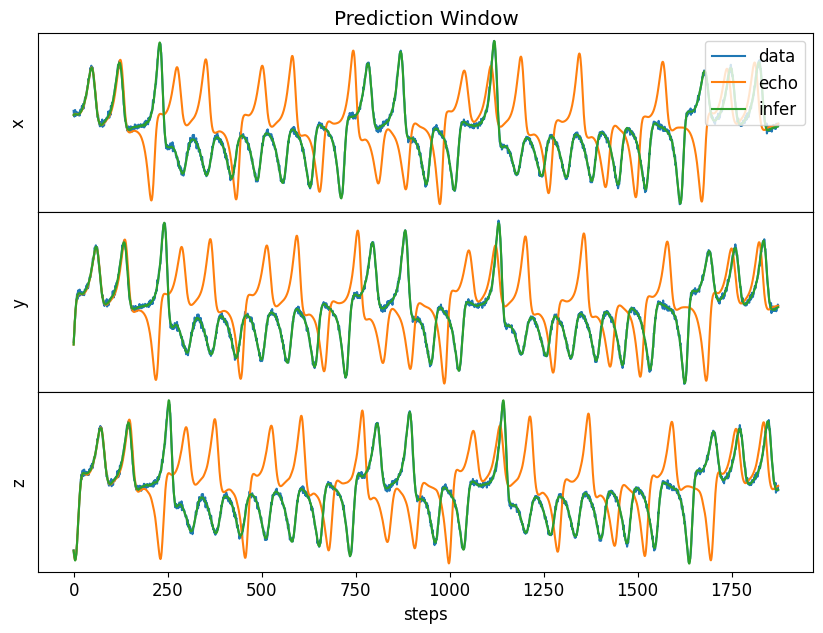

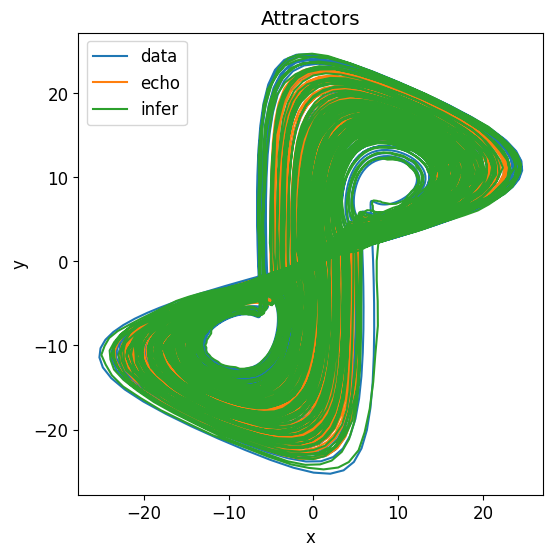

In [9]:
np.random.seed(11111)
N = 100
ds = 0.2
rho = 0.99
sigma = 5/max(np.max(y_in,1)-np.min(y_in,1))

# RC = mapRC(N,bias=True)
RC = diffRC(N,ds,bias=False)


RC.makeConnectionMat(rho,degree=5,loc=-1,scale=1)
RC.makeInputMat(1,sigma,randMin=-1,randMax=1)

RC.listen(y_in)
RC.train(y_target,alpha=0.000,mask=[[1,0,0]])
RC.echo(Mpred)

driveIndex =[0]

RC.infer(y_target_pred[driveIndex],driveIndex)
y_infer = RC.W@RC.r_infer
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [10, 7]
fig,axs = plt.subplots(D,sharex='col')
fig.subplots_adjust(hspace=0)
labelList = ['x','y','z']
for i in range(D):
    axs[i].plot(y_target_pred[i,:Mplot],label='data')
    axs[i].plot(RC.y_echo[i,:Mplot],label='echo')
    axs[i].plot(y_infer[i,:Mplot],label='infer')
    axs[i].set_xlabel('steps')
    axs[i].set_yticks([])
    axs[i].set_ylabel(labelList[i])
axs[0].legend(loc='upper right')
axs[0].set_title('Prediction Window')
plt.show()

plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(x_target_pred[0],x_target_pred[1],label='data')
plt.plot(RC.y_echo[0],RC.y_echo[1],label='echo')
plt.plot(y_infer[0],y_infer[1],label='infer')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Attractors')
plt.legend()
plt.show()

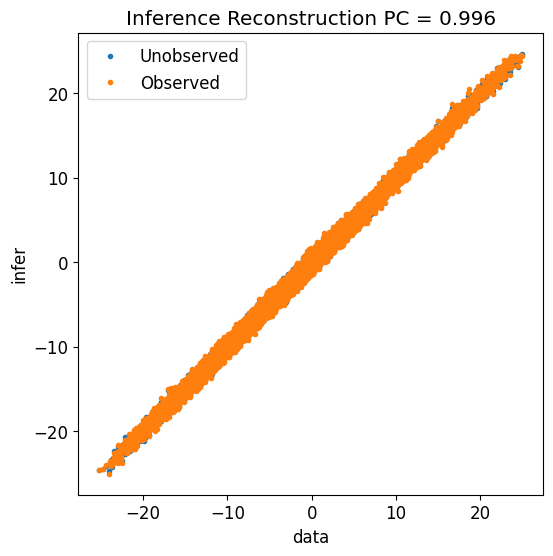

In [10]:
PCmat = RC.inferPC(y_target_pred)
plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(y_target_pred[1],y_infer[1],'.')
plt.plot(y_target_pred[0],y_infer[0],'.')
plt.xlabel('data')
plt.ylabel('infer')
plt.title(f'Inference Reconstruction PC = {PCmat[0,0]:0.3f}')
plt.legend(['Unobserved','Observed'])
plt.show()